# Assignment 2

In [1]:
# importing relevant libraries
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction import FeatureHasher
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

In [2]:
# dataset reading
ROOT_DIR = "/Users/nikunjlad"   # defining the root dir
data = pd.read_csv(os.path.join(ROOT_DIR, "data") + "/loan.csv")   # reading the csv file using pandas
data.head()   # observing the head of the dataframe

,Sex,Age,Time_at_address,Res_status,Telephone,Occupation,Job_status,Time_employed,Time_bank,Liab_ref,Acc_ref,Home_Expn,Balance,Decision
0,M,50.750000,0.585,owner,given,unemploye,unemploye,0,0,f,given,145,0,reject
1,M,19.670000,10.000,rent,not_given,labourer,governmen,0,0,t,given,140,0,reject
2,F,52.830002,15.000,owner,given,creative_,private_s,5,14,f,given,0,2200,accept
3,M,22.670000,2.540,rent,not_given,creative_,governmen,2,0,f,given,0,0,accept
4,M,29.250000,13.000,owner,given,driver,governmen,0,0,f,given,228,0,reject


In [3]:
data.shape

(429, 14)

In [4]:
data.isna().sum()

Sex                0
Age                0
Time_at_address    0
Res_status         0
Telephone          0
Occupation         0
Job_status         0
Time_employed      0
Time_bank          0
Liab_ref           0
Acc_ref            0
Home_Expn          0
Balance            0
Decision           0
dtype: int64

The data seems to have 429 rows and 14 columns

In [5]:
# finding unique values
def get_unique_values(cols):
    
    unique_dict = dict()
    for col in cols:
        obs = list()
        obs.append(list(data[col].unique()))
        obs.append(len(obs[0]))
        unique_dict[col] = obs
        
    return unique_dict

In [6]:
query_cols = ["Sex", "Res_status", "Telephone", "Liab_ref", "Acc_ref", "Decision"]

In [7]:
data["Occupation"].unique()

array(['unemploye', 'labourer', 'creative_', 'driver', 'professio',
       'manager', 'guard_etc', 'executive', 'office_st', 'productio',
       'semi_pro', 'sales'], dtype=object)

In [8]:
unique_cols_dict = get_unique_values(query_cols)
unique_cols_dict

{'Sex': [['M', 'F'], 2],
 'Res_status': [['owner', 'rent'], 2],
 'Telephone': [['given', 'not_given'], 2],
 'Liab_ref': [['f', 't'], 2],
 'Acc_ref': [['given', 'oth_inst_'], 2],
 'Decision': [['reject', 'accept'], 2]}

In [9]:
def label_features(feature_list):
    
    feature_labels = list()
    feature_mappings = list()
    for feature in feature_list:
        gle = LabelEncoder()
        feature_labels.append(gle.fit_transform(data[feature]))
        feature_mappings.append({index: label for index, label in enumerate(gle.classes_)})
    return feature_labels, feature_mappings

In [10]:
labels, mappings = label_features(query_cols)
for ind, col in enumerate(query_cols):
    data[col] = labels[ind]

In [11]:
data.head()

,Sex,Age,Time_at_address,Res_status,Telephone,Occupation,Job_status,Time_employed,Time_bank,Liab_ref,Acc_ref,Home_Expn,Balance,Decision
0,1,50.750000,0.585,0,0,unemploye,unemploye,0,0,0,0,145,0,1
1,1,19.670000,10.000,1,1,labourer,governmen,0,0,1,0,140,0,1
2,0,52.830002,15.000,0,0,creative_,private_s,5,14,0,0,0,2200,0
3,1,22.670000,2.540,1,1,creative_,governmen,2,0,0,0,0,0,0
4,1,29.250000,13.000,0,0,driver,governmen,0,0,0,0,228,0,1


In [12]:
def feature_hasher(feature, num):
    
    fh = FeatureHasher(n_features=num, input_type='string')
    hashed_features = fh.fit_transform(data[feature])
    hashed_features = hashed_features.toarray()
    col_names = [feature + str(n) for n in range(num)]
    df = pd.concat([data, pd.DataFrame(hashed_features, columns=col_names)], axis=1)
    return df

data = feature_hasher("Occupation", 5)
data = feature_hasher("Job_status", 3)
data = data.drop(["Occupation", "Job_status"], axis=1)
data.head()

,Sex,Age,Time_at_address,Res_status,Telephone,Time_employed,Time_bank,Liab_ref,Acc_ref,Home_Expn,Balance,Decision,Occupation0,Occupation1,Occupation2,Occupation3,Occupation4,Job_status0,Job_status1,Job_status2
0,1,50.750000,0.585,0,0,0,0,0,0,145,0,1,0.0,0.0,2.0,1.0,2.0,-2.0,6.0,1.0
1,1,19.670000,10.000,1,1,0,0,1,0,140,0,1,3.0,-1.0,2.0,1.0,1.0,-2.0,5.0,-2.0
2,0,52.830002,15.000,0,0,5,14,0,0,0,2200,0,2.0,-1.0,-1.0,0.0,1.0,-3.0,2.0,0.0
3,1,22.670000,2.540,1,1,2,0,0,0,0,0,0,2.0,-1.0,-1.0,0.0,1.0,-2.0,5.0,-2.0
4,1,29.250000,13.000,0,0,0,0,0,0,228,0,1,2.0,-1.0,0.0,-1.0,2.0,-2.0,5.0,-2.0


In [13]:
data.describe()

,Sex,Age,Time_at_address,Res_status,Telephone,Time_employed,Time_bank,Liab_ref,Acc_ref,Home_Expn,Balance,Decision,Occupation0,Occupation1,Occupation2,Occupation3,Occupation4,Job_status0,Job_status1,Job_status2
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.678322,31.510163,4.650758,0.226107,0.226107,1.871795,2.279720,0.456876,0.072261,176.727273,898.382284,0.552448,1.428904,-0.799534,-0.067599,1.118881,0.466200,-2.557110,3.018648,-0.046620
std,0.467666,11.843595,4.804037,0.418798,0.418798,3.254023,3.966105,0.498718,0.259222,142.590659,3814.565340,0.497822,1.017466,0.774536,1.103350,1.383259,1.014797,0.666016,1.453204,1.274359
min,0.000000,15.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-1.000000,-1.000000,-1.000000,-4.000000,2.000000,-2.000000
25%,0.000000,22.670000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000,0.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,-3.000000,2.000000,0.000000
50%,1.000000,28.500000,2.750000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,160.000000,10.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,1.000000,-3.000000,2.000000,0.000000
75%,1.000000,38.250000,7.000000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,272.000000,484.000000,1.000000,2.000000,0.000000,0.000000,2.000000,1.000000,-2.000000,5.000000,0.000000
max,1.000000,76.750000,25.209999,1.000000,1.000000,20.000000,23.000000,1.000000,1.000000,760.000000,51100.000000,1.000000,3.000000,1.000000,2.000000,4.000000,2.000000,-1.000000,6.000000,3.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1387febe0>,
      dtype=object)

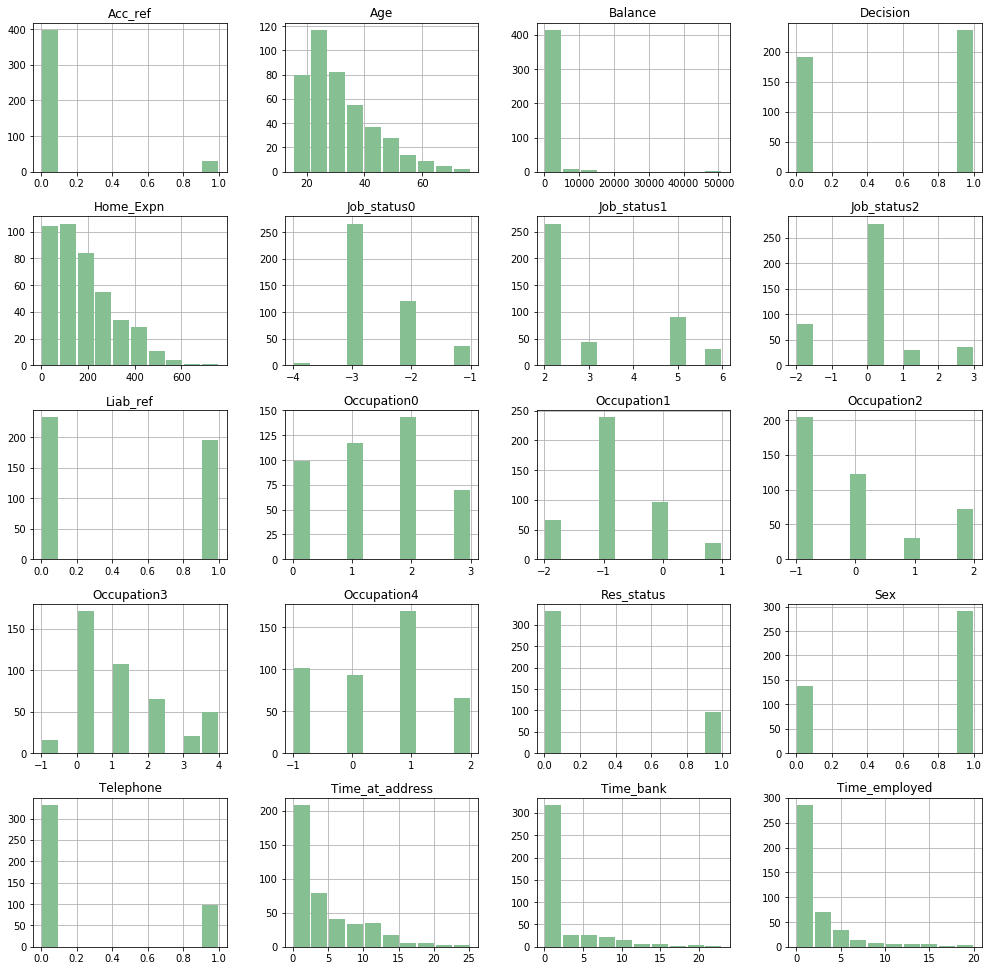

In [14]:
data.hist(figsize=(17,17), color='#86bf91', zorder=2, rwidth=0.9)

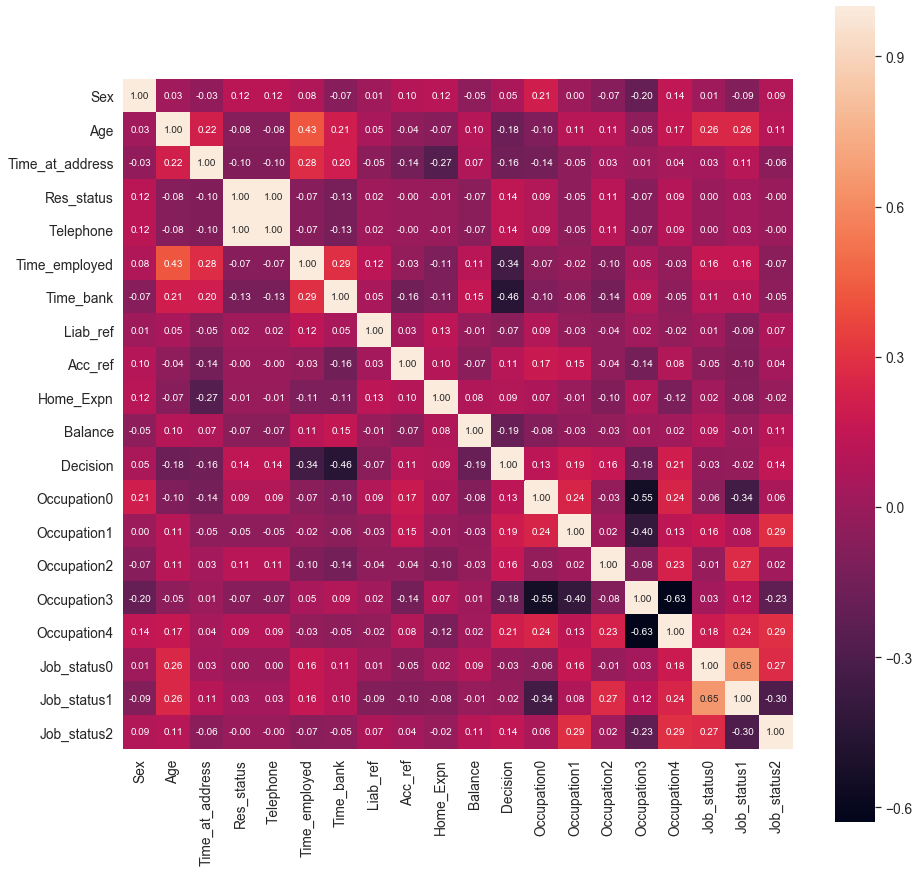

In [15]:
corr = data.corr()
cols = corr.index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(15, 15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The correlation matrix above gives information about the strength of the relationship between variables. We only look at the bottom half of the matrix, below the diagonal since the upper half of the triangle consists of the same values. The positive values denote positive covariance i.e if one variable increases another increases too, while negative value indicates negative covariance, i.e if one variable decreases another increases and vice-versa. How strong is this variation is given by the magnitude of this values. That is essentially correlation. It gives strength of covariance in a particular direction.

From the above correlation matrix, we need to find variables which have impact on our target variable of Decision as to whether a loan will be rejected or approved. The variables which show strong correlation are:

1. Time_bank
2. Time_employed
3. All occupations (only 1,2,3 4)
4. Balance
5. Age
6. Time_at_address
7. Job_status2

Hence we select only these columns for predictions since they have higher probability for decision making.


In [16]:
df = data[["Age","Time_at_address","Time_employed","Time_bank","Balance","Occupation1","Occupation2","Occupation3",
            "Occupation4"]]
df.head()

,Age,Time_at_address,Time_employed,Time_bank,Balance,Occupation1,Occupation2,Occupation3,Occupation4
0,50.750000,0.585,0,0,0,0.0,2.0,1.0,2.0
1,19.670000,10.000,0,0,0,-1.0,2.0,1.0,1.0
2,52.830002,15.000,5,14,2200,-1.0,-1.0,0.0,1.0
3,22.670000,2.540,2,0,0,-1.0,-1.0,0.0,1.0
4,29.250000,13.000,0,0,0,-1.0,0.0,-1.0,2.0


In [17]:
x = df.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=df.columns)
df.head()

,Age,Time_at_address,Time_employed,Time_bank,Balance,Occupation1,Occupation2,Occupation3,Occupation4
0,0.577785,0.023205,0.00,0.000000,0.000000,0.666667,1.000000,0.4,1.000000
1,0.073076,0.396668,0.00,0.000000,0.000000,0.333333,1.000000,0.4,0.666667
2,0.611562,0.595002,0.25,0.608696,0.043053,0.333333,0.000000,0.2,0.666667
3,0.121793,0.100754,0.10,0.000000,0.000000,0.333333,0.000000,0.2,0.666667
4,0.228646,0.515668,0.00,0.000000,0.000000,0.333333,0.333333,0.0,1.000000


In [18]:
df["Decision"] = data["Decision"]
df.head()

,Age,Time_at_address,Time_employed,Time_bank,Balance,Occupation1,Occupation2,Occupation3,Occupation4,Decision
0,0.577785,0.023205,0.00,0.000000,0.000000,0.666667,1.000000,0.4,1.000000,1
1,0.073076,0.396668,0.00,0.000000,0.000000,0.333333,1.000000,0.4,0.666667,1
2,0.611562,0.595002,0.25,0.608696,0.043053,0.333333,0.000000,0.2,0.666667,0
3,0.121793,0.100754,0.10,0.000000,0.000000,0.333333,0.000000,0.2,0.666667,0
4,0.228646,0.515668,0.00,0.000000,0.000000,0.333333,0.333333,0.0,1.000000,1


In [19]:
class create_dataset(Dataset):
    
    def __init__(self, data):
        self.data = torch.tensor(data.values)
        self.x = self.data[:,:-1].type(torch.float32)
        self.y = self.data[:,-1].type(torch.int64)
        self.num_samples = self.data.shape[0]
    
    def get_item(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.num_samples

In [21]:
dataset = create_dataset(df)
batch_size = 8
train_split = .88
valid_split = 0.08
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_split = int(np.floor(train_split * dataset_size))
valid_split = int(np.floor(valid_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, valid_indices, test_indices = indices[:train_split], indices[train_split:train_split + valid_split], indices[train_split + valid_split:]
                                            
print(len(train_indices), len(valid_indices), len(test_indices))
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)
dataset = TensorDataset(dataset.x, dataset.y)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
train_loader
validation_loader = torch.utils.data.DataLoader(dataset, sampler=valid_sampler)

377 34 18


In [196]:
#  = TensorDataset(train_dataset.x, train_dataset.y)
# batch_size = 10
# train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

In [24]:
class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(9, 16)
            self.fc2 = nn.Linear(32, 16)
            self.fc3 = nn.Linear(16, 2)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(x)

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=9, out_features=16, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)


<bound method Module.cpu of Net(
  (fc1): Linear(in_features=9, out_features=16, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)>

In [23]:
learning_rate = 0.01
# create a stochastic gradient descent optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)
# create a loss function
criterion = nn.NLLLoss()
epochs = 60

# run the main training loop
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data = data.view(-1, 9)
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % batch_size == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.data.item()))
            
            
# run a test loop
test_loss = 0
correct = 0
for data, target in validation_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    data = data.view(-1, 9)
    net_out = net(data)
    # sum up batch loss
    test_loss += criterion(net_out, target).data.item()
    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    correct += pred.eq(target.data).sum()

test_loss /= len(validation_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(validation_loader.dataset),
    100. * correct / len(validation_loader.dataset)))

Net(
  (fc1): Linear(in_features=9, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)
Train Epoch: 0 [0/429 (0%)]	Loss: 0.633192
Train Epoch: 0 [64/429 (17%)]	Loss: 0.759962
Train Epoch: 0 [128/429 (33%)]	Loss: 0.722625
Train Epoch: 0 [192/429 (50%)]	Loss: 0.678186
Train Epoch: 0 [256/429 (67%)]	Loss: 0.697044
Train Epoch: 0 [320/429 (83%)]	Loss: 0.703673
Train Epoch: 1 [0/429 (0%)]	Loss: 0.695708
Train Epoch: 1 [64/429 (17%)]	Loss: 0.686557
Train Epoch: 1 [128/429 (33%)]	Loss: 0.691201
Train Epoch: 1 [192/429 (50%)]	Loss: 0.696431
Train Epoch: 1 [256/429 (67%)]	Loss: 0.684543
Train Epoch: 1 [320/429 (83%)]	Loss: 0.694295
Train Epoch: 2 [0/429 (0%)]	Loss: 0.677868
Train Epoch: 2 [64/429 (17%)]	Loss: 0.677879
Train Epoch: 2 [128/429 (33%)]	Loss: 0.692981
Train Epoch: 2 [192/429 (50%)]	Loss: 0.660787
Train Epoch: 2 [256/429 (67%)]	Loss: 0.713760
Train Epoch: 2 [320/429 (83%)]	Loss: 0.695269

Train Epoch: 33 [320/429 (83%)]	Loss: 0.585398
Train Epoch: 34 [0/429 (0%)]	Loss: 0.381215
Train Epoch: 34 [64/429 (17%)]	Loss: 0.502230
Train Epoch: 34 [128/429 (33%)]	Loss: 0.653054
Train Epoch: 34 [192/429 (50%)]	Loss: 0.501107
Train Epoch: 34 [256/429 (67%)]	Loss: 0.497485
Train Epoch: 34 [320/429 (83%)]	Loss: 0.652615
Train Epoch: 35 [0/429 (0%)]	Loss: 0.597259
Train Epoch: 35 [64/429 (17%)]	Loss: 0.547861
Train Epoch: 35 [128/429 (33%)]	Loss: 0.454722
Train Epoch: 35 [192/429 (50%)]	Loss: 0.745317
Train Epoch: 35 [256/429 (67%)]	Loss: 0.542729
Train Epoch: 35 [320/429 (83%)]	Loss: 0.448207
Train Epoch: 36 [0/429 (0%)]	Loss: 0.540860
Train Epoch: 36 [64/429 (17%)]	Loss: 0.531173
Train Epoch: 36 [128/429 (33%)]	Loss: 0.341488
Train Epoch: 36 [192/429 (50%)]	Loss: 0.290253
Train Epoch: 36 [256/429 (67%)]	Loss: 0.655234
Train Epoch: 36 [320/429 (83%)]	Loss: 0.382242
Train Epoch: 37 [0/429 (0%)]	Loss: 0.535408
Train Epoch: 37 [64/429 (17%)]	Loss: 0.555121
Train Epoch: 37 [128/429 (33%